<a href="https://colab.research.google.com/github/descandon88/Analisis-de-Redes/blob/main/analisis_predictivo_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import seaborn as sns

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import accuracy_score

import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
print("conexión con drive listo!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
conexión con drive listo!


####Traemos las bases de Complejidad Económica que obtuvimos en el blog de notas anterior

In [ ]:
df_pci = pd.read_csv("/content/drive/MyDrive/eci/base/df_pci.csv")
df_location= pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
df_country_code= pd.read_csv("/content/drive/MyDrive/eci/base/df_country_code.csv")


In [ ]:
result_pci_country_code = pd.merge(df_country_code, df_pci , on="country_name")
df_new = result_pci_country_code.copy()
column_names = ["location_id", "country_code", "country_name","product_code","export_value","year","eci","pci"]
print("Se reordenan el orden de las columnas")

df_c = df_new.reindex(columns=column_names)
df_c.head()

Se reordenan el orden de las columnas


,location_id,country_code,country_name,product_code,export_value,year,eci,pci
0,0,ABW,Aruba,6805,0,1995,-0.149358,3.005267
1,0,ABW,Aruba,9204,0,1995,-0.149358,3.880273
2,0,ABW,Aruba,2911,0,1995,-0.149358,3.770268
3,0,ABW,Aruba,2918,0,1995,-0.149358,2.371247
4,0,ABW,Aruba,2917,0,1995,-0.149358,1.504703


In [ ]:
df=df_c.copy()
df.head()

,location_id,country_code,country_name,product_code,export_value,year,eci,pci
0,0,ABW,Aruba,6805,0,1995,-0.149358,3.005267
1,0,ABW,Aruba,9204,0,1995,-0.149358,3.880273
2,0,ABW,Aruba,2911,0,1995,-0.149358,3.770268
3,0,ABW,Aruba,2918,0,1995,-0.149358,2.371247
4,0,ABW,Aruba,2917,0,1995,-0.149358,1.504703


In [ ]:
df=df.drop(columns=['country_code', 'country_name'])
df=df.sort_values(by=['location_id','product_code','year'])

In [ ]:
df.head(10)

,location_id,product_code,export_value,year,eci,pci
490,0,101,18008,1995,-0.149358,1.204200
1731,0,101,0,1996,-0.376153,1.016136
2972,0,101,0,1997,-0.664343,1.118762
4213,0,101,0,1998,0.330030,1.180892
5454,0,101,14473,1999,0.006876,0.954775
6696,0,101,0,2000,0.312097,1.246471
7938,0,101,11249,2001,0.141701,1.019034
9180,0,101,9019,2002,-0.189418,1.277552
10422,0,101,8613,2003,-0.199274,1.358104
11664,0,101,0,2004,-0.468775,1.252575


###modificamos la base, donde agregamos columnas que refieran a la variable ECI y PCI desde t-1 hasta t-5.

In [ ]:
#df_1 = df.groupby(["location_id","product_code","year"],as_index = True)
df['pcit-1'] = df.groupby(['location_id','product_code'])['pci'].shift(+1)
df['pcit-2'] = df.groupby(['location_id','product_code'])['pci'].shift(+2)
df['pcit-3'] = df.groupby(['location_id','product_code'])['pci'].shift(+3)
df['pcit-4'] = df.groupby(['location_id','product_code'])['pci'].shift(+4)
df['pcit-5'] = df.groupby(['location_id','product_code'])['pci'].shift(+5)
df['ecit-1'] = df.groupby(['location_id','product_code'])['eci'].shift(+1)
df['ecit-2'] = df.groupby(['location_id','product_code'])['eci'].shift(+2)
df['ecit-3'] = df.groupby(['location_id','product_code'])['eci'].shift(+3)
df['ecit-4'] = df.groupby(['location_id','product_code'])['eci'].shift(+4)
df['ecit-5'] = df.groupby(['location_id','product_code'])['eci'].shift(+5)
df=df.fillna(0)
df = df[df.year != 2020]
df1 = df.copy()

In [ ]:
df1.head(4)

,location_id,product_code,export_value,year,eci,pci,pcit-1,pcit-2,pcit-3,pcit-4,pcit-5,ecit-1,ecit-2,ecit-3,ecit-4,ecit-5
490,0,101,18008,1995,-0.149358,1.204200,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1731,0,101,0,1996,-0.376153,1.016136,1.204200,0.000000,0.0000,0.0,0.0,-0.149358,0.000000,0.000000,0.0,0.0
2972,0,101,0,1997,-0.664343,1.118762,1.016136,1.204200,0.0000,0.0,0.0,-0.376153,-0.149358,0.000000,0.0,0.0
4213,0,101,0,1998,0.330030,1.180892,1.118762,1.016136,1.2042,0.0,0.0,-0.664343,-0.376153,-0.149358,0.0,0.0


In [ ]:
df2=df.sort_values(by=['year','location_id','product_code']).copy()
df2 = df2[df2.export_value != 0]

df2.head()

,location_id,product_code,export_value,year,eci,pci,pcit-1,pcit-2,pcit-3,pcit-4,pcit-5,ecit-1,ecit-2,ecit-3,ecit-4,ecit-5
490,0,101,18008,1995,-0.149358,1.204200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,0,106,2336,1995,-0.149358,-2.112441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1173,0,404,46234,1995,-0.149358,2.508095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0,406,566704,1995,-0.149358,1.680372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0,604,20855,1995,-0.149358,-0.592346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###Selecciono y segmento las variables "y" de predicción

In [ ]:
df_y=df2.loc[(df2['year']>1999)&(df2['year']<=2019)]
Y =  df_y.iloc[:,[5]]
#Y =  df_y.loc[:,['pci']].values
df_y17=df2.loc[(df2['year']>1999)&(df2['year']<=2017)]
Y17 =  df_y17.iloc[:,[5]]
df_y18=df2.loc[(df2['year']==2018)]
Y18 =  df_y18.iloc[:,[5]]
df_y19=df2.loc[(df2['year']==2019)]
Y19 =  df_y19.iloc[:,[5]]
Y.tail()

Y17.tail()

,pci
7310987,1.004752
7311043,0.634849
7310325,-0.366895
7310146,-0.862501
7310332,0.572796


In [ ]:
df_x_train=df2.loc[ (df2['year']>1999)&(df2['year']<=2019)]

dfx_17=df2.loc[ (df2['year']>1999)&(df2['year']<=2017)]
dfx_18=df2.loc[ (df2['year']==2018)]
dfx_19=df2.loc[ (df2['year']==2019)]

df_x_train=df_x_train.iloc[:, [i for i in range(df_x_train.shape[1]) if i != 5]]
dfx_17=dfx_17.iloc[:, [i for i in range(dfx_17.shape[1]) if i != 5]]
dfx_18=dfx_18.iloc[:, [i for i in range(dfx_18.shape[1]) if i != 5]]
dfx_19=dfx_19.iloc[:, [i for i in range(dfx_19.shape[1]) if i != 5]]

X = df_x_train.iloc[:,0:16]
X17=dfx_17.iloc[:,0:16]
X18=dfx_18.iloc[:,0:16]
X19=dfx_19.iloc[:,0:16]
X.tail()
X17.tail()
X19.tail()
#X[0,0:14]
#df_x.head(5)
#type(X)

,location_id,product_code,export_value,year,eci,pcit-1,pcit-2,pcit-3,pcit-4,pcit-5,ecit-1,ecit-2,ecit-3,ecit-4,ecit-5
7313427,250,9703,22774132,2019,1.250292,0.211592,1.004752,0.077898,0.435453,0.414686,0.673645,0.669892,0.732298,0.659868,0.486857
7313483,250,9704,272016,2019,1.250292,0.382832,0.634849,0.316733,0.040149,0.309810,0.673645,0.669892,0.732298,0.659868,0.486857
7312766,250,9705,29850106,2019,1.250292,-0.713955,-0.366895,0.057390,-0.929038,-0.273465,0.673645,0.669892,0.732298,0.659868,0.486857
7312587,250,9706,68972424,2019,1.250292,-2.189002,-0.862501,-1.476492,-1.447281,-1.443447,0.673645,0.669892,0.732298,0.659868,0.486857
7312773,250,9999,51257131008,2019,1.250292,0.571061,0.572796,1.020175,0.165245,0.754914,0.673645,0.669892,0.732298,0.659868,0.486857


### Asignamos los sets de Train, Test y Validation según los años.


*   Train: base desde 2000 - 2017
*   Validation: Base para el 2018
*   Test: Base para el 2019






In [ ]:
from sklearn.model_selection import GroupShuffleSplit

#gs = GroupShuffleSplit(n_splits=2, test_size=.1, random_state=0)

#train_ix, test_ix = next(gs.split(X17, Y, groups=X['year']==2019))

#X_train = X.iloc[train_ix]
X_train =X17

#y_train = Y.iloc[train_ix]
y_train = Y17

#X_test = X.iloc[test_ix]
X_test = X19
#y_test = Y.iloc[test_ix]
y_test = Y19

#X_val =   X.iloc[val_iy]
X_val =   X18
#y_val = Y.iloc[val_iy]
y_val = Y18


print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))




y_train

X_train shape: (2664689, 15)
X_test shape: (145843, 15)
y_train shape: (2664689, 1)
y_test shape: (145843, 1)
X_val shape: (150884, 15)
y_val shape: (150884, 1)


,pci
6262,-1.911484
6853,2.425090
6588,-2.059270
6584,-1.692482
6495,-2.553491
...,...
7310987,1.004752
7311043,0.634849
7310325,-0.366895
7310146,-0.862501


In [ ]:
from sklearn.ensemble import RandomForestRegressor

#model = RandomForestRegressor(n_estimators=10, random_state=30)
regressor = RandomForestRegressor(n_estimators=25,random_state=1)
regressor.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=25, random_state=1)

In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred=regressor.predict(X_test)
# Printing the metrics
mae=metrics.mean_absolute_error(y_test, y_pred)
mse=metrics.mean_squared_error(y_test, y_pred)
print('Random Forest Regression Accuracy: ', regressor.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred))
print('MAE: ', mae)
print('MSE: ', mse)

Random Forest Regression Accuracy:  0.9067551334381808
R2 square: 0.9067551334381808
MAE:  0.3658379367959215
MSE:  0.22957127020768434


In [ ]:
from sklearn.metrics import mean_absolute_error
y_pred_val=regressor.predict(X_val)
# Printing the metrics
maev=metrics.mean_absolute_error(y_val, y_pred_val)
msev=metrics.mean_squared_error(y_val, y_pred_val)
print('Random Forest Regression Accuracy  (over validataion set): ', regressor.score(X_val,y_val))
print('R2 square (validataion set):',metrics.r2_score(y_val, y_pred_val))
print('MAE (validataion set): ', maev)
print('MSE (validation set): ', msev)

Random Forest Regression Accuracy  (over validataion set):  0.8998055329137451
R2 square (validataion set): 0.8998055329137451
MAE (validataion set):  0.353729886886925
MSE (validation set):  0.27401038033911534


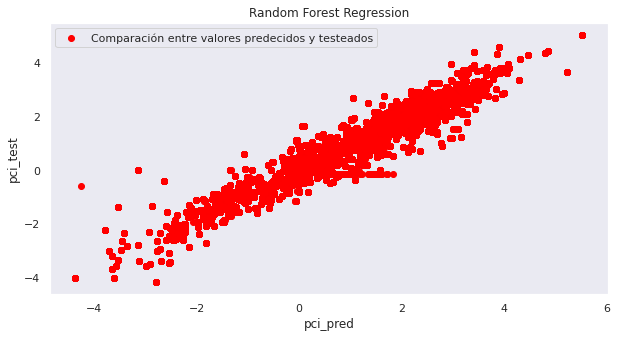

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(y_pred, y_test, color= "red", label ="Comparación entre valores predecidos y testeados")
plt.legend()
plt.grid()
plt.title("Random Forest Regression")
plt.xlabel("pci_pred")
plt.ylabel("pci_test")
plt.show()

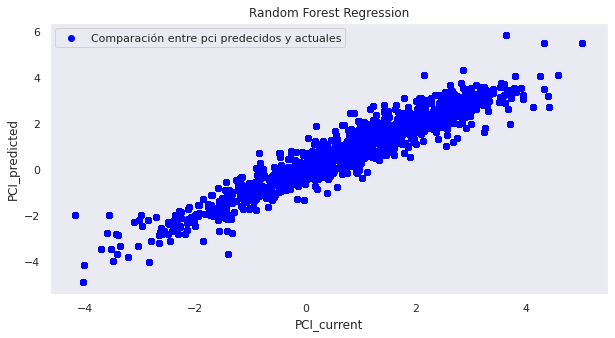

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pci_test, pci_pred_val, color= "blue", label ="Comparación entre pci predecidos y actuales")
plt.legend()
plt.grid()
plt.title("Random Forest Regression")
plt.xlabel("PCI_current")
plt.ylabel("PCI_predicted")
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


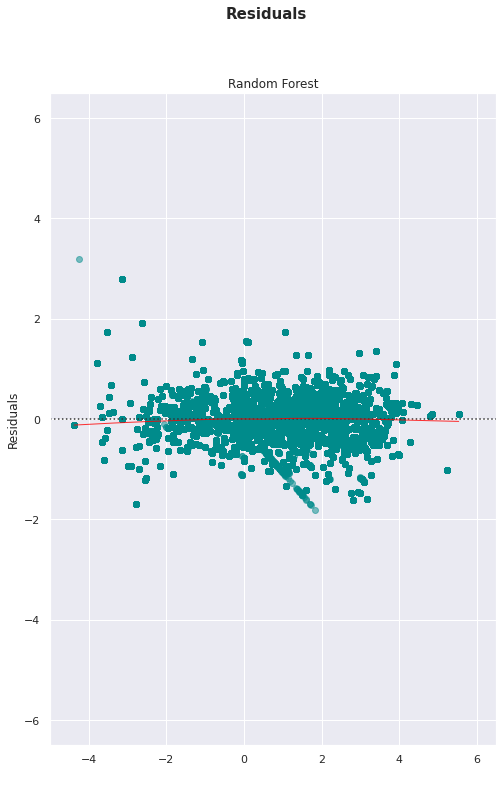

In [ ]:
fig, axes =plt.subplots(figsize=(8,12))
fig.suptitle('Residuals', fontweight="bold", fontsize=15)
# Random Forest ###############################
axes= sns.residplot(ax=axes, x=y_pred, y=y_test, data=df1, 
                          lowess=True, 
                          color='darkcyan',
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axes.set_xlim([-5, 6.5])
axes.set_ylim([-6.5, 6.5])
axes.set_title('Random Forest')
axes.set_xlabel(' ')
axes.set_ylabel('Residuals')

plt.show()

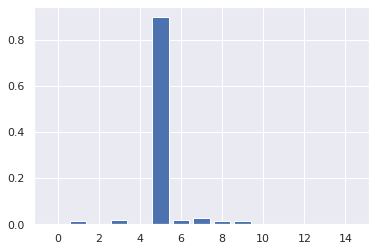

In [ ]:
from matplotlib import pyplot
# get importance
importance_train = regressor.feature_importances_
#importance_val = regressor_val.feature_importances_

# summarize feature importance
#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance_train))], importance_train)
#pyplot.bar([x for x in range(len(importance_val))], importance_val)

pyplot.show()

In [ ]:
y_pred.shape

(592284,)